In [1]:
import os
import shutil
#from PIL import Image
import matplotlib.image as mpimg
%matplotlib inline

import pandas as pd
import numpy as np
import random

import re
import json

#!pip install tensorflow-gpu
#!pip install -q --upgrade tensorflow
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import datasets, layers, models, losses, Model #draw graphs
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt #draw graphs
import os
import tensorflow as tf



from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3 #transfer learning model
from tensorflow.keras.utils import plot_model

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import optimizers


from sklearn.preprocessing import OneHotEncoder

2.6.0


In [2]:
def allocate_data(frac_total=0.4):
    """
    """
    # Creating the base dir
    base_dir = 'base_dir'
    if os.path.isdir(base_dir):
        shutil.rmtree(base_dir)
        os.mkdir(base_dir)
    else:
        os.mkdir(base_dir)
        
    # Creating train and validation dir
    train_dir = os.path.join(base_dir, "train_dir")
    if not os.path.isdir(train_dir):
        os.mkdir(train_dir)
        
    val_dir = os.path.join(base_dir, "val_dir")
    if not os.path.isdir(val_dir):
        os.mkdir(val_dir)
    
    
    # Getting the different labels
    json_labels = '/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json'
    with open(json_labels) as json_file:
        labels = json.load(json_file)
        #data_keys = data.keys()
        labels = {key : labels[key].replace(" ", "_") for key in labels.keys()} 
        #print(labels)
    
    # Creating the labels' directories
    for d in [train_dir, val_dir]:
        for label in labels.values():
            t_dir = os.path.join(d, label)
            if not os.path.isdir(t_dir):
                os.mkdir(t_dir)
                
    print(f"Directories for training: {os.listdir(train_dir)}")
    print(f"Directories for validation: {os.listdir(val_dir)}")
    
    # Load labels dataframe and sample it for train and validation
    labels_df = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
    #print(labels_df.head())
    labels_df = labels_df.groupby('label').apply(lambda x: x.sample(frac=frac_total))
    train_sample = labels_df.sample(frac = 0.70, replace=False, random_state=1998)
    val_sample = labels_df.drop(train_sample.index)    
    train_sample_dict = train_sample.to_dict() 
    val_sample_dict = val_sample.to_dict() 
    
    #print(train_sample_dict['image_id'].values())
    #print(f"Train : {len(train_images_id)}, Validation : {len(val_images_id)}")
    print(f"Train : {len(train_sample_dict['image_id'])}, Validation : {len(val_sample_dict['image_id'])}")
    
    # Transfer the images
    train_images_dir = "../input/cassava-leaf-disease-classification/train_images"
    ## Train dir
    #test = []
    for image_key, image_value in train_sample_dict['image_id'].items():
        label_ = train_sample_dict['label'][image_key]
        label = labels[str(label_)]
        image = str(image_value)
        #test.append(image)
        src = os.path.join(train_images_dir, image)
        dst = os.path.join(train_dir, label, image)
        shutil.copyfile(src, dst)
    #print(test)
        
    ## Validation dir
    for image_key, image_value in val_sample_dict['image_id'].items():
        label_ = val_sample_dict['label'][image_key]
        label = labels[str(label_)]
        image = str(image_value)
        #test.append(image)
        src = os.path.join(train_images_dir, image)
        dst = os.path.join(val_dir, label, image)
        shutil.copyfile(src, dst)
    
    print("\nTrain set:\n")
    total = 0
    for label in labels.values():
        t = os.path.join(train_dir, label)
        total += len(os.listdir(t))
        print(f"Length of {label} in {train_dir} is: {len(os.listdir(t))}")
    print(f"\nTotal: {total}")
    print("\nVal set:\n")
    
    total = 0
    for label in labels.values():
        t = os.path.join(val_dir, label)
        total += len(os.listdir(t))
        print(f"Length of {label} in {val_dir} is: {len(os.listdir(t))}")
    print(f"\nTotal: {total}")

In [3]:
allocate_data()

Directories for training: ['Healthy', 'Cassava_Brown_Streak_Disease_(CBSD)', 'Cassava_Green_Mottle_(CGM)', 'Cassava_Bacterial_Blight_(CBB)', 'Cassava_Mosaic_Disease_(CMD)']
Directories for validation: ['Healthy', 'Cassava_Brown_Streak_Disease_(CBSD)', 'Cassava_Green_Mottle_(CGM)', 'Cassava_Bacterial_Blight_(CBB)', 'Cassava_Mosaic_Disease_(CMD)']
Train : 5991, Validation : 2568

Train set:

Length of Cassava_Bacterial_Blight_(CBB) in base_dir/train_dir is: 296
Length of Cassava_Brown_Streak_Disease_(CBSD) in base_dir/train_dir is: 604
Length of Cassava_Green_Mottle_(CGM) in base_dir/train_dir is: 654
Length of Cassava_Mosaic_Disease_(CMD) in base_dir/train_dir is: 3731
Length of Healthy in base_dir/train_dir is: 706

Total: 5991

Val set:

Length of Cassava_Bacterial_Blight_(CBB) in base_dir/val_dir is: 139
Length of Cassava_Brown_Streak_Disease_(CBSD) in base_dir/val_dir is: 272
Length of Cassava_Green_Mottle_(CGM) in base_dir/val_dir is: 300
Length of Cassava_Mosaic_Disease_(CMD) in b

In [4]:
def import_images_paths(n=5, is_random=False):
    train_path = './base_dir/train_dir'
    train_directories = os.listdir(train_path)
    
    paths_dict = {}
    for x in train_directories:
        t_join = os.path.join(train_path, x)
        t_listdir = os.listdir(t_join)
        t_len_listdir = len(t_listdir)
        if is_random:
            t_listdir = [t_listdir[i] for i in random.sample(range(0, t_len_listdir + 1), n)]
        else:
            t_listdir = os.listdir(t_join)[:n]
        paths_dict[x] = [os.path.join(t_join, y) for y in t_listdir]
        #print(os.listdir(os.path.join(train_path, x))[:5])
    return paths_dict

In [5]:
def import_images(n=5, is_random=False):
    paths_dict = import_images_paths(n, is_random)
    
    images_dict = {}
    for key, values in paths_dict.items():
        t_list_images = []
        for value in values:
            t_list_images.append(mpimg.imread(value))
        images_dict[key] = t_list_images
    
    return images_dict

In [6]:
#import_images_paths()

In [7]:
def plot_images(n=5, is_random=False):
    images_dict = import_images(n, is_random)
    
    #plt.figure(figsize=(20,10))
    
    columns = n#5
    lines = len(images_dict.keys())#1
    fig, ax = plt.subplots(lines, columns, figsize=(8 * 2.5, 6 * 2.5))
    
    i = 0
    for key, values in images_dict.items():
        for j, image in enumerate(values):
            #plt.subplot(lines, columns, j + 1) #(len(images) / columns + 1, columns, i + 1)
            ax[i, j].imshow(image, aspect='auto')
            ax[i, j].set_title(key)
        i += 1
    #plt.tight_layout()

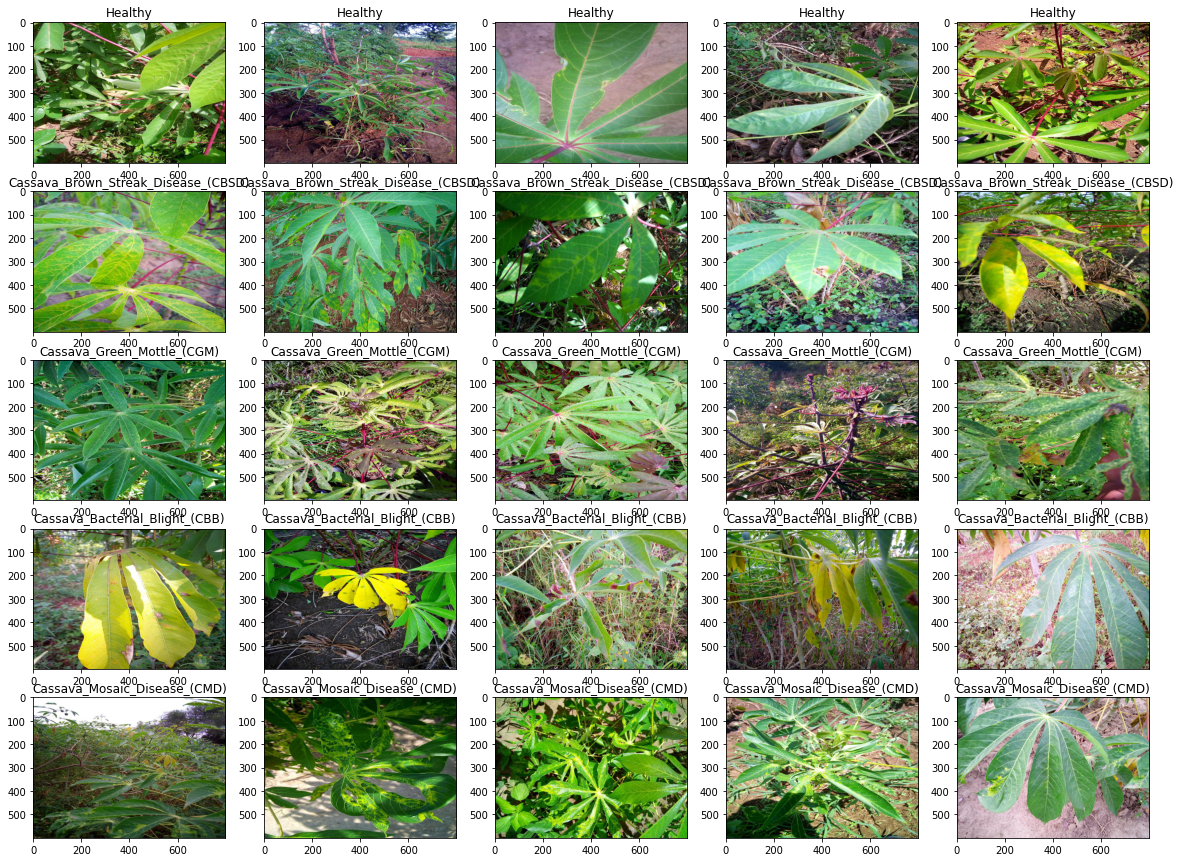

In [8]:
plot_images(is_random=False)

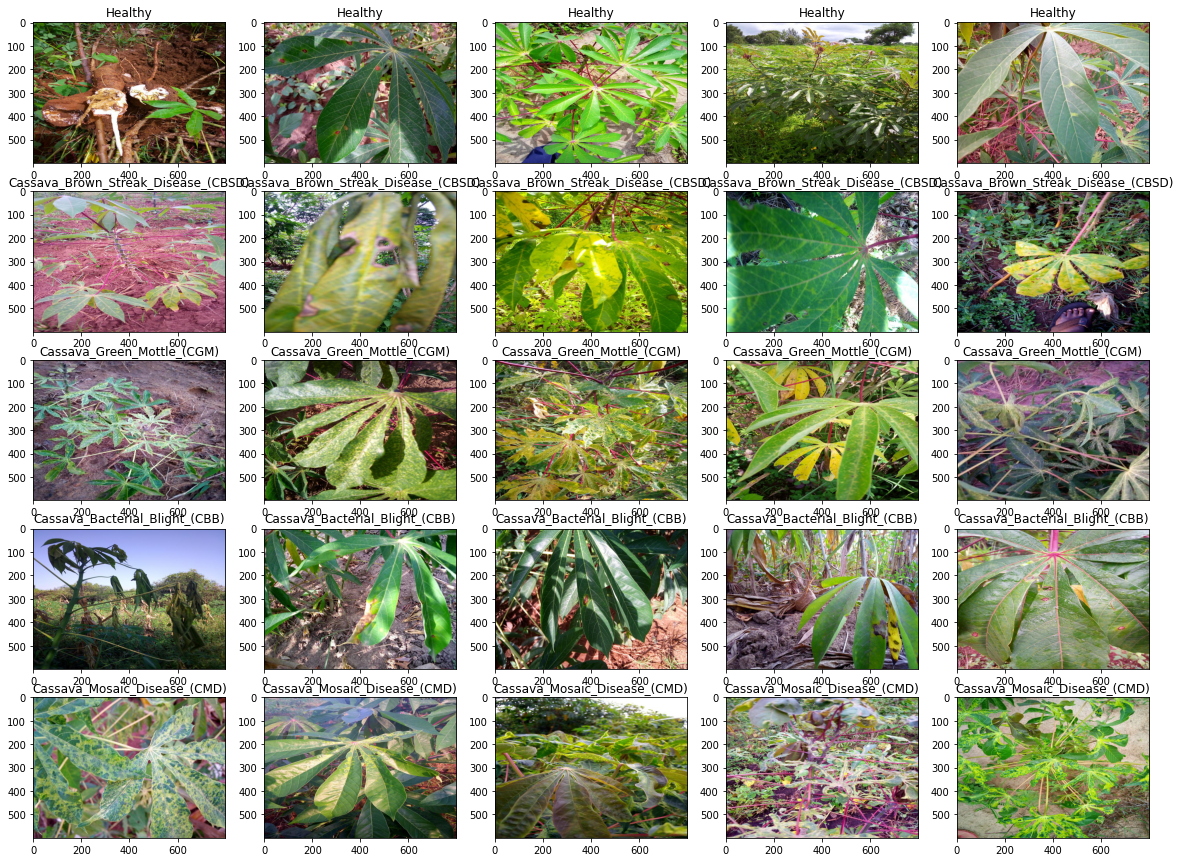

In [9]:
plot_images(is_random=True)

In [10]:
def print_diseases_repartition(is_train=True):
    if is_train:
        path = './base_dir/train_dir'
    else:
        path = './base_dir/val_dir'
    directories = os.listdir(path)
    
    total = 0
    count_dict = {}
    for x in directories:
        t_join = os.path.join(path, x)
        t_listdir = os.listdir(t_join)
        t_len_listdir = len(t_listdir)
        total += t_len_listdir
        count_dict[x] = t_len_listdir
    
    count_prop = {}
    for key, value in count_dict.items():
        count_prop[key] = round((value / total), 2)
        
    return(count_prop)

In [11]:
print_diseases_repartition()

{'Healthy': 0.12,
 'Cassava_Brown_Streak_Disease_(CBSD)': 0.1,
 'Cassava_Green_Mottle_(CGM)': 0.11,
 'Cassava_Bacterial_Blight_(CBB)': 0.05,
 'Cassava_Mosaic_Disease_(CMD)': 0.62}

In [12]:
def rgb2gray(image):
    return np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

In [13]:
def plot_images_hist(n=5, is_random=False, is_rgb=True):
    """
    """
    images_dict = import_images(n, is_random)
    
    #plt.figure(figsize=(20,10))
    
    columns = n#5
    lines = len(images_dict.keys())#1
    coef = 3
    fig, ax = plt.subplots(lines, columns, figsize=(8 * coef, 6 * coef))
    
    if is_rgb:
        colors = ("R", "G", "B")
        channels = (0, 1, 2)
    
    i = 0
    for key, values in images_dict.items():
        for j, image in enumerate(values):
            if is_rgb:
                for channel, color in zip(channels, colors):
                    #subfigs = fig.subfigures(1, 3)
                    ax[i, j].hist(image[:, :, channel].ravel(), bins=256, range=(0, 256), color=color.lower())
                    ax[i, j].set_title(key)
                    ax[i, j].set_xlabel("Color Value")
                    ax[i, j].set_ylabel("Pixels")
            else:
                rgb2gray(image)
                ax[i, j].hist(image.ravel(), bins=256, range=(0.0, 1.0))
                ax[i, j].set_xlabel("Color Value")
                ax[i, j].set_ylabel("Pixels")
                ax[i, j].set_title(key)        
        i += 1
    plt.tight_layout()

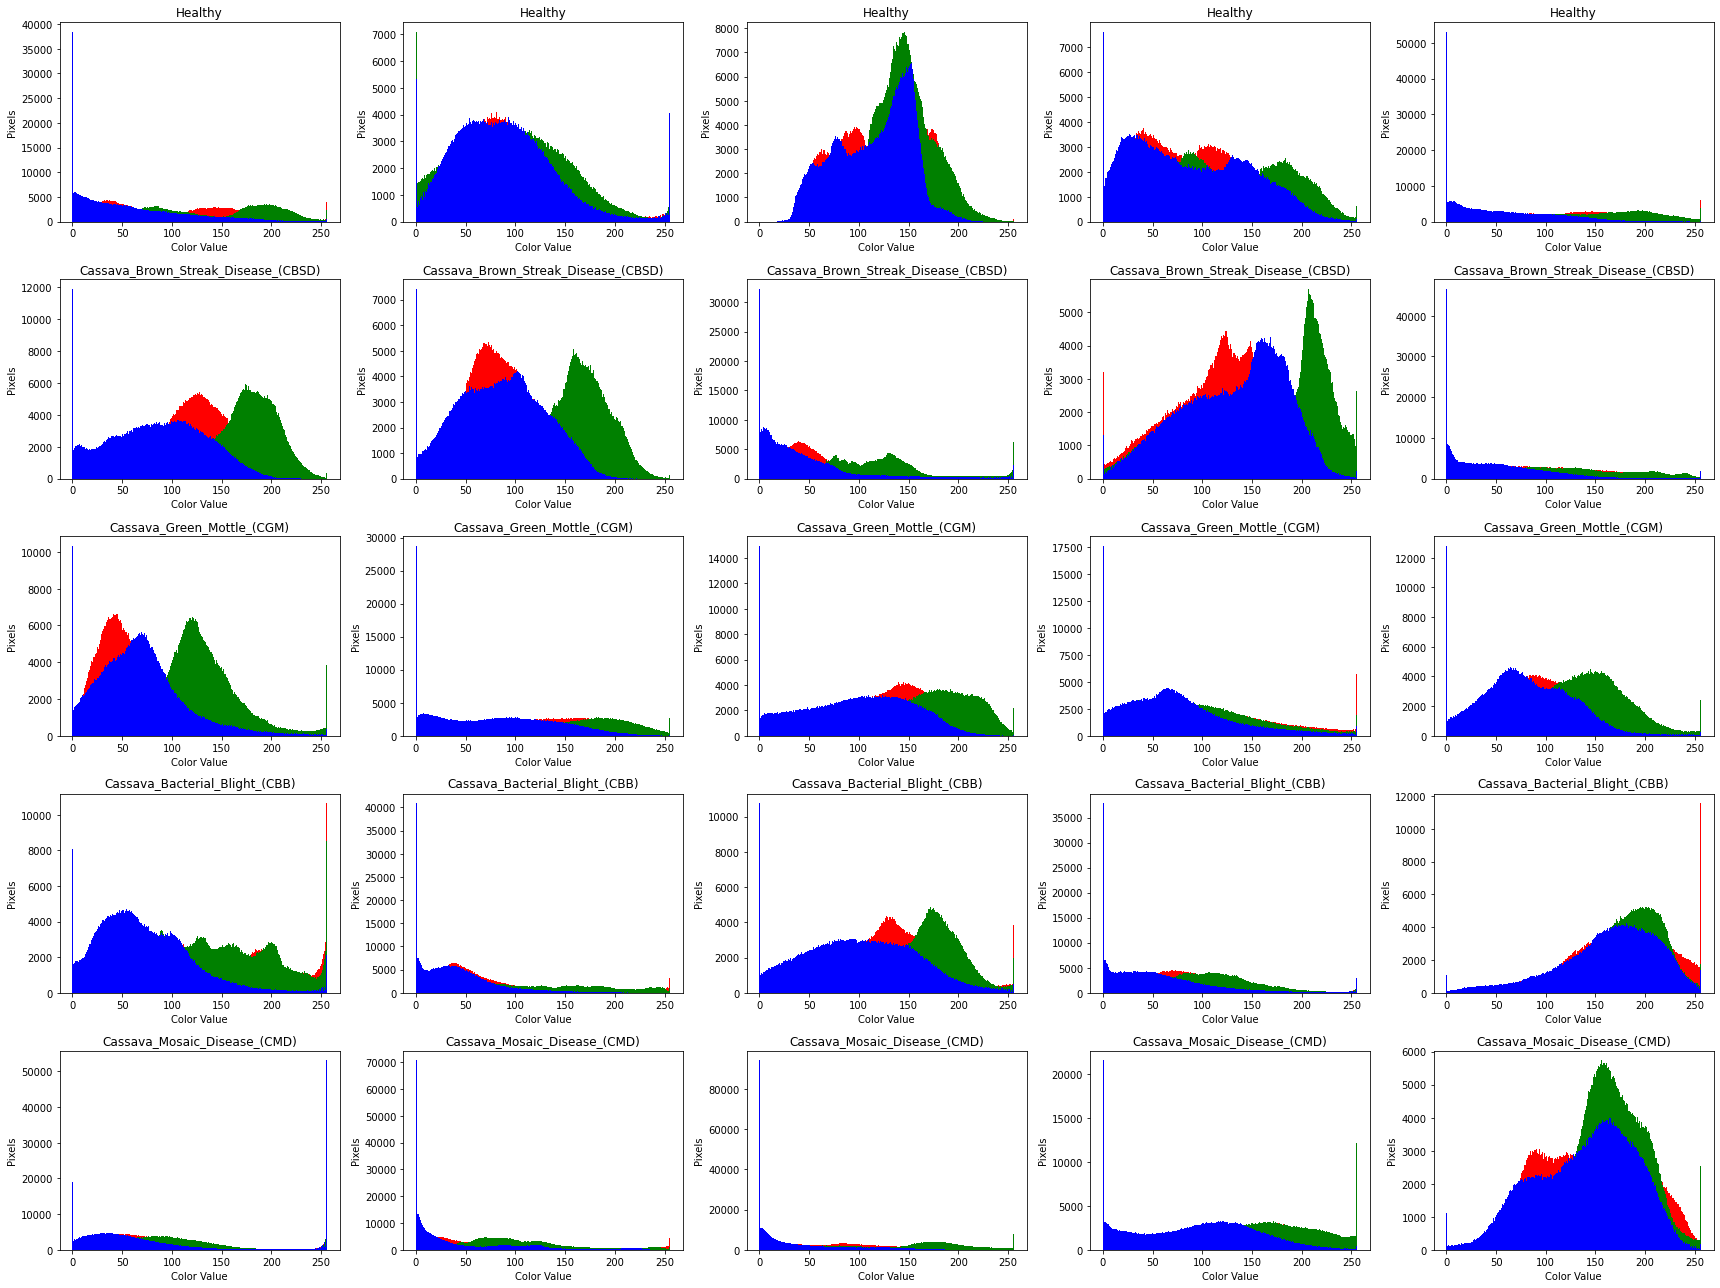

In [14]:
plot_images_hist(n=5, is_random=False, is_rgb=True)

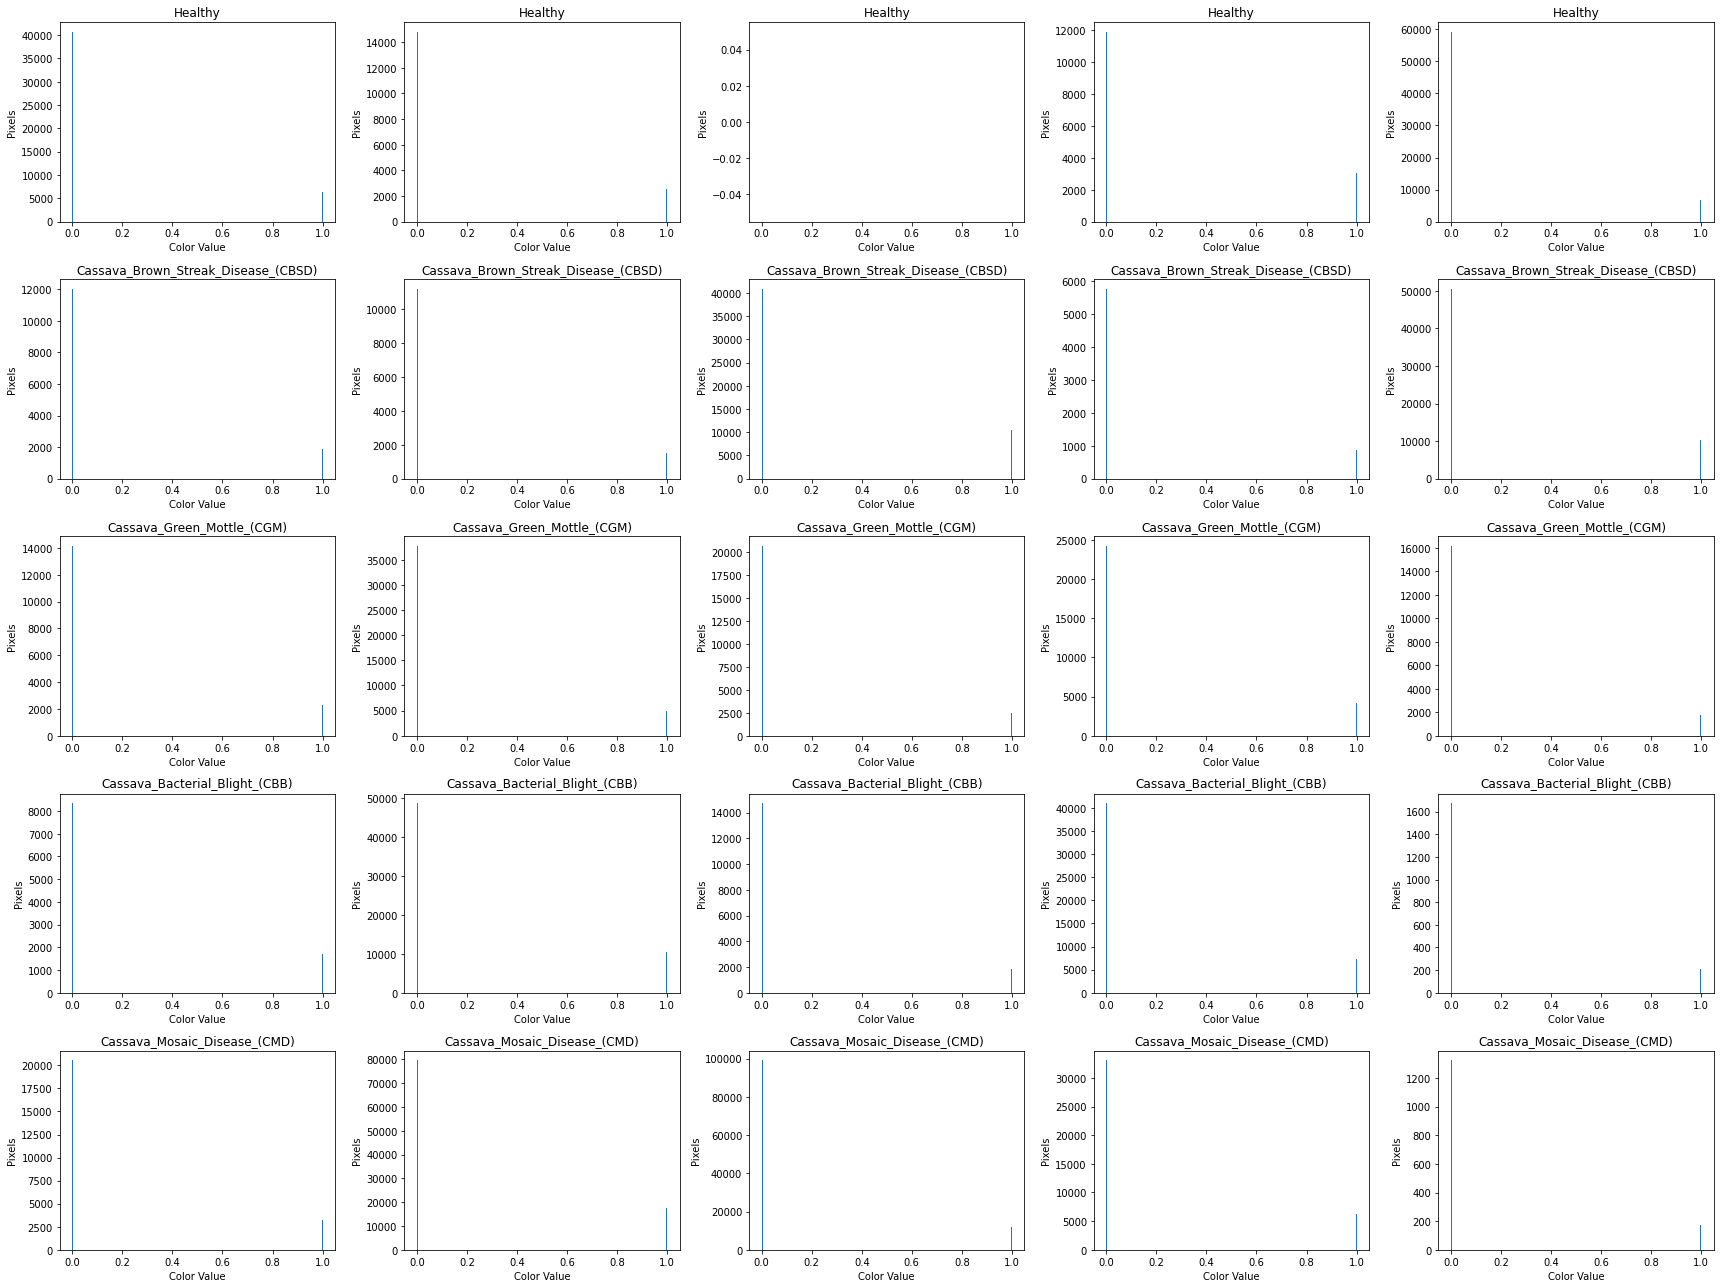

In [15]:
plot_images_hist(n=5, is_random=False, is_rgb=False)
# true values ?

In [16]:
def get_image_stats(n=5, is_random=False):
    """
    """
    images_dict = import_images(n, is_random)
    
    colors = ("R", "G", "B")
    channels = (0, 1, 2)
    
    mean_col_dict = {}
    
    for key, values in images_dict.items():
        R_list = []
        G_list = []
        B_list = []
        for i, value in enumerate(values):
            for channel, color in zip(channels, colors):
                if color == "R":
                    R_list.append(np.mean(value[:, :, channel]))
                elif color == "G":
                    G_list.append(np.mean(value[:, :, channel]))
                else:
                    B_list.append(np.mean(value[:, :, channel]))
        mean_col_dict[key] = (np.mean(R_list), np.mean(G_list), np.mean(B_list))
    
    return mean_col_dict

In [17]:
get_image_stats(n = 100)

{'Healthy': (109.8735570625, 124.46476510416666, 81.59887583333334),
 'Cassava_Brown_Streak_Disease_(CBSD)': (107.28399364583336,
  122.0959645625,
  76.03142877083333),
 'Cassava_Green_Mottle_(CGM)': (112.63699750000002,
  128.8406809375,
  84.21251499999998),
 'Cassava_Bacterial_Blight_(CBB)': (105.48185189583336,
  120.35613425,
  67.76706339583333),
 'Cassava_Mosaic_Disease_(CMD)': (112.9423095625,
  127.11148672916666,
  85.78937264583334)}

In [18]:
def create_generators(color_mode="rgb", batch_size=64):
    """
    """
    train_path = './base_dir/train_dir'
    val_path = './base_dir/val_dir'
    #test_path =
    
    train_directories = os.listdir(train_path)
    val_directories = os.listdir(val_path)
    
    num_train_samples = sum([len(os.listdir(os.path.join(train_path, x))) for x in train_directories])
    num_val_samples = sum([len(os.listdir(os.path.join(val_path, x))) for x in val_directories])
    print(num_train_samples)
    print(num_val_samples)
    
    train_batch_size = batch_size
    val_batch_size = batch_size
    
    train_steps = np.ceil(num_train_samples / train_batch_size)
    val_steps = np.ceil(num_val_samples / val_batch_size)
    
    datagen = ImageDataGenerator(rescale=1.0/255)

    train_gen = datagen.flow_from_directory(train_path,
                                            target_size=(256,256),
                                            color_mode=color_mode,#"grayscale", #"rgb"
                                            batch_size=train_batch_size,
                                            class_mode='categorical')

    val_gen = datagen.flow_from_directory(val_path,
                                            target_size=(256,256),
                                            color_mode=color_mode,#"grayscale", #"rgb"
                                            batch_size=val_batch_size,
                                            class_mode='categorical')
    
    return train_gen, val_gen, train_steps, val_steps

def plot_history(history, metric="loss"):
    nb_epochs = range(1, history.params["epochs"] + 1)
    plt.plot(nb_epochs, history.history[metric], label = metric)
    plt.plot(nb_epochs, history.history["val_" + metric], label = "val_" + metric)
    plt.legend()
    

In [19]:
def create_model(classification_type = 'softmax'):
    """
    """
    
    base_model = keras.applications.vgg19.VGG19(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(256, 256, 3),
        include_top=False,
    )
    base_model.trainable = False # freeze base_model
    
    input_shape = (256, 256, 3)
    inputs = keras.Input(shape=input_shape)
    scale_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1) # [-1, 1]
    x = scale_layer(inputs)
    #x=inputs/255
    
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(5, activation=classification_type)(x)
    model = keras.Model(inputs, outputs)    
    model.summary()
    
    return model

def compile_and_fit(model):
    """
    """
    with tf.device('/GPU:0'):
        train_gen, val_gen, train_steps, val_steps = create_generators("rgb")

        model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.RMSprop(lr=1e-4),
        metrics=['acc'])

        #BATCH_SIZE = 16
        epochs = 10
        #creuser ça 
        filepath = "VGG19_TPUmodel.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                                 save_best_only=True, mode='max')
        reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                       verbose=1, mode='max', min_lr=0.00001)
        callbacks_list = [checkpoint, reduce_lr]
    
        history = model.fit(
            train_gen,
            steps_per_epoch=train_steps,
            validation_data=val_gen,
            validation_steps=val_steps,
            epochs = epochs,
            callbacks=callbacks_list)
    
    return history

In [20]:
model = create_model()
history = compile_and_fit(model)

2021-11-19 16:45:18.686417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 16:45:18.796175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 16:45:18.796906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 16:45:18.798078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 20,026,949
Trainable params: 2,565
Non-trainable

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2021-11-19 16:45:22.858933: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-19 16:45:24.989151: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


94/94 [==============================] - 97s 911ms/step - loss: 1.4063 - acc: 0.4308 - val_loss: 1.2390 - val_acc: 0.5966

Epoch 00001: val_acc improved from -inf to 0.59657, saving model to VGG19_TPUmodel.h5
Epoch 2/10
94/94 [==============================] - 80s 853ms/step - loss: 1.2678 - acc: 0.5979 - val_loss: 1.2200 - val_acc: 0.5966

Epoch 00002: val_acc did not improve from 0.59657
Epoch 3/10
94/94 [==============================] - 81s 865ms/step - loss: 1.2439 - acc: 0.6159 - val_loss: 1.2222 - val_acc: 0.5966

Epoch 00003: val_acc did not improve from 0.59657

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 4/10
94/94 [==============================] - 81s 864ms/step - loss: 1.2400 - acc: 0.6184 - val_loss: 1.2230 - val_acc: 0.5966

Epoch 00004: val_acc did not improve from 0.59657
Epoch 5/10
94/94 [==============================] - 81s 864ms/step - loss: 1.2369 - acc: 0.6209 - val_loss: 1.2225 - val_acc: 0.5966

Epoch 00005: val_acc did

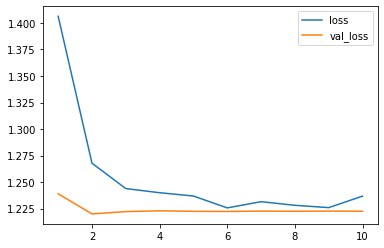

In [21]:
plot_history(history)

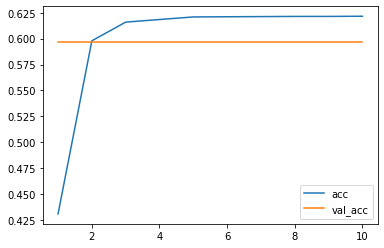

In [22]:
plot_history(history, "acc")